# Ini

Code based on the repository https://github.com/lifanchen-simm/transformerCPI

Data (13022 examples):
- Compounds: list with all the molucules (mol.GetNumAtoms(), num_atom_feat=34) 
- Adjacencies: Adjacency matrix of each molecule (AdjacencyMatrix(mol),Chem.GetAdjacencyMatrix(mol))
- Proteins: for each protein, get protein embedding,infer a list of 3-mers to (num_word,100) matrix. For each sequence, use word2vec to obtain the data

The data is in GPCR_train, each element is a compound, a protein (sequence), and the interaction from the compound and the protein. 
1. From the compound it takes the compound.npy, which is consists of, for each compound, all the atoms it contains and for each atom all its features. Therefore, in compounds, for each compound it has a shape e.g. [31,34], which is 31 atoms and 34 features for each atom
2. From the compound it also takes the adjacency matrix, saved as adjacencies.npy, which reflects the position of each atom, and whether it is bonded with another atom (value 1) or not (value 0).
3. Then, from the file it also takes sequences, which refers to the protein that interact with that said compound. It applies word2vec and list of 3-mers to obtain a (num_word,100) matrix for each protein (sequence), where num_word is the number of words in the sequence.
4. Interaction: whether the compound or molecule interacts with the protein or not.



Dataset train has a length of aprox 10000 examples, and each example has 4 elements, which are (compounds, adjacencies, proteins, interactions)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)  

Mounted at /content/drive


In [ ]:
%cd  /content/drive/MyDrive/Colab_Notebooks/comp_bio

/content/drive/MyDrive/Colab_Notebooks/comp_bio


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch
import numpy as np
import random
import os
import time
# from model import *
import timeit
import os
from datetime import datetime

In [ ]:
!pip install import-ipynb

In [ ]:
def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in np.load(file_name + '.npy', allow_pickle=True)]


def shuffle_dataset(dataset, seed):
    np.random.seed(seed)
    np.random.shuffle(dataset)
    return dataset


def split_dataset(dataset, ratio):
    n = int(ratio * len(dataset))
    dataset_1, dataset_2 = dataset[:n], dataset[n:]
    return dataset_1, dataset_2

In [ ]:
# '''Careful!!! when importing from another notebook, in the other notebook there cannot be the drive.mount(), otherwise it raises error'''
# import import_ipynb
# import model
# from model import Encoder, Decoder, Predictor, Trainer, Tester, DecoderLayer, SelfAttention, PositionwiseFeedforward 

In [ ]:
if __name__ == "__main__":
    SEED = 1
    random.seed(SEED)
    torch.manual_seed(SEED)
    # torch.backends.cudnn.deterministic = True
    DATASET = "GPCR_train"
    """CPU or GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print('The code uses GPU...')
    else:
        device = torch.device('cpu')
        print('The code uses CPU!!!')

    """Load preprocessed data."""
    dir_input = ('dataset/' + DATASET + '/word2vec_30/')
    compounds = load_tensor(dir_input + 'compounds', torch.FloatTensor)
    adjacencies = load_tensor(dir_input + 'adjacencies', torch.FloatTensor)
    proteins = load_tensor(dir_input + 'proteins', torch.FloatTensor)
    interactions = load_tensor(dir_input + 'interactions', torch.LongTensor)

The code uses CPU!!!


# Model

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive') 
# %cd  /content/drive/MyDrive/Colab_Notebooks/comp_bio

In [ ]:
!pip install import-ipynb

In [ ]:
import import_ipynb
import Radam
import lookahead
from lookahead import Lookahead
from Radam import AdamW, PlainRAdam, RAdam

importing Jupyter notebook from Radam.ipynb
importing Jupyter notebook from lookahead.ipynb


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score,precision_recall_curve, auc
# from Radam import *
# from lookahead import Lookahead

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_heads = n_heads

        assert hid_dim % n_heads == 0

        self.w_q = nn.Linear(hid_dim, hid_dim)
        self.w_k = nn.Linear(hid_dim, hid_dim)
        self.w_v = nn.Linear(hid_dim, hid_dim)

        self.fc = nn.Linear(hid_dim, hid_dim)

        self.do = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim // n_heads])).to(device)

    def forward(self, query, key, value, mask=None):
        '''Summary: takes Query, Key, Values matrices and copmute score. For that, compute the entropy(or Energy). 
        Then, apply softmax and compute the product of that with the Value matrix. It does a lot of reshapes'''
        bsz = query.shape[0]

        # query = key = value [batch size, sent len, hid dim]

        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)

        # Q, K, V = [batch size, sent len, hid dim]

        Q = Q.view(bsz, -1, self.n_heads, self.hid_dim // self.n_heads).permute(0, 2, 1, 3)
        K = K.view(bsz, -1, self.n_heads, self.hid_dim // self.n_heads).permute(0, 2, 1, 3)
        V = V.view(bsz, -1, self.n_heads, self.hid_dim // self.n_heads).permute(0, 2, 1, 3)

        # K, V = [batch size, n heads, sent len_K, hid dim // n heads]
        # Q = [batch size, n heads, sent len_q, hid dim // n heads]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy = [batch size, n heads, sent len_Q, sent len_K]
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = self.do(F.softmax(energy, dim=-1))

        # attention = [batch size, n heads, sent len_Q, sent len_K]

        x = torch.matmul(attention, V)

        # x = [batch size, n heads, sent len_Q, hid dim // n heads]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x = [batch size, sent len_Q, n heads, hid dim // n heads]

        x = x.view(bsz, -1, self.n_heads * (self.hid_dim // self.n_heads))

        # x = [batch size, src sent len_Q, hid dim]

        x = self.fc(x)

        # x = [batch size, sent len_Q, hid dim]

        return x

In [ ]:
class Encoder(nn.Module):
    """protein feature extraction."""
    def __init__(self, protein_dim, hid_dim, n_layers,kernel_size , dropout, device):
        super().__init__()

        assert kernel_size % 2 == 1, "Kernel size must be odd (for now)"

        self.input_dim = protein_dim
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.dropout = dropout
        self.n_layers = n_layers
        self.device = device
        #self.pos_embedding = nn.Embedding(1000, hid_dim)
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.convs = nn.ModuleList([nn.Conv1d(hid_dim, 2*hid_dim, kernel_size, padding=(kernel_size-1)//2) for _ in range(self.n_layers)])   # convolutional layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.input_dim, self.hid_dim)
        self.gn = nn.GroupNorm(8, hid_dim * 2)
        self.ln = nn.LayerNorm(hid_dim)

    def forward(self, protein):
        '''Takes the protein and applies a feed forward, and a loop of: dropout, convolutional, GLU activation function,
        residual connection and layer normalization'''
        #pos = torch.arange(0, protein.shape[1]).unsqueeze(0).repeat(protein.shape[0], 1).to(self.device)
        #protein = protein + self.pos_embedding(pos)
        #protein = [batch size, protein len,protein_dim]
        conv_input = self.fc(protein)
        # conv_input=[batch size,protein len,hid dim]
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1)
        #conv_input = [batch size, hid dim, protein len]
        for i, conv in enumerate(self.convs):
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))
            #conved = [batch size, 2*hid dim, protein len]

            #pass through GLU activation function
            conved = F.glu(conved, dim=1)
            #conved = [batch size, hid dim, protein len]

            #apply residual connection / high way
            conved = (conved + conv_input) * self.scale
            #conved = [batch size, hid dim, protein len]

            #set conv_input to conved for next loop iteration
            conv_input = conved

        conved = conved.permute(0, 2, 1)
        # conved = [batch size,protein len,hid dim]
        conved = self.ln(conved)
        return conved


In [ ]:
class PositionwiseFeedforward(nn.Module):
    '''https://ai.stackexchange.com/questions/15524/why-would-you-implement-the-position-wise-feed-forward-network-of-the-transforme 
    In this class an input w/ (input,hidden) goes through fc layer to (input,pf_dim) and goes back to (input,hidden)
    This is done to approximate well a function thanks to using a veery wide fc layer'''
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.pf_dim = pf_dim

        self.fc_1 = nn.Conv1d(hid_dim, pf_dim, 1)  # convolution neural units
        self.fc_2 = nn.Conv1d(pf_dim, hid_dim, 1)  # convolution neural units

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, sent len, hid dim]

        x = x.permute(0, 2, 1)

        # x = [batch size, hid dim, sent len]

        x = self.do(F.relu(self.fc_1(x)))

        # x = [batch size, pf dim, sent len]

        x = self.fc_2(x)

        # x = [batch size, hid dim, sent len]

        x = x.permute(0, 2, 1)

        # x = [batch size, sent len, hid dim]

        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, self_attention, positionwise_feedforward, dropout, device):
        super().__init__()

        self.ln = nn.LayerNorm(hid_dim)
        self.sa = self_attention(hid_dim, n_heads, dropout, device)
        self.ea = self_attention(hid_dim, n_heads, dropout, device)
        self.pf = positionwise_feedforward(hid_dim, pf_dim, dropout)
        self.do = nn.Dropout(dropout)

    def forward(self, trg, src, trg_mask=None, src_mask=None):
        # trg = [batch_size, compound len, atom_dim]
        # src = [batch_size, protein len, hid_dim] # encoder output
        # trg_mask = [batch size, compound sent len]
        # src_mask = [batch size, protein len]

        trg = self.ln(trg + self.do(self.sa(trg, trg, trg, trg_mask)))
        
        trg = self.ln(trg + self.do(self.ea(trg, src, src, src_mask)))

        trg = self.ln(trg + self.do(self.ea(trg, src, src, src_mask)))

        trg = self.ln(trg + self.do(self.ea(trg, src, src, src_mask)))

        trg = self.ln(trg + self.do(self.pf(trg)))

        return trg


class Decoder(nn.Module):
    """ compound feature extraction."""
    def __init__(self, atom_dim, hid_dim, n_layers, n_heads, pf_dim, decoder_layer, self_attention,
                 positionwise_feedforward, dropout, device):
        super().__init__()
        self.ln = nn.LayerNorm(hid_dim)
        self.output_dim = atom_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.pf_dim = pf_dim
        self.decoder_layer = decoder_layer
        self.self_attention = self_attention
        self.positionwise_feedforward = positionwise_feedforward
        self.dropout = dropout
        self.device = device
        self.sa = self_attention(hid_dim, n_heads, dropout, device)
        self.layers = nn.ModuleList(
            [decoder_layer(hid_dim, n_heads, pf_dim, self_attention, positionwise_feedforward, dropout, device)
             for _ in range(n_layers)])
        self.ft = nn.Linear(atom_dim, hid_dim)
        self.do = nn.Dropout(dropout)
        self.fc_1 = nn.Linear(hid_dim, 256)
        self.fc_2 = nn.Linear(256, 2)
        self.gn = nn.GroupNorm(8, 256)

    def forward(self, trg, src, trg_mask=None,src_mask=None):
        # trg = [batch_size, compound len, atom_dim]
        # src = [batch_size, protein len, hid_dim] # encoder output
        trg = self.ft(trg)

        # trg = [batch size, compound len, hid dim]

        for layer in self.layers:
            trg = layer(trg, src,trg_mask,src_mask)

        # trg = [batch size, compound len, hid dim]
        """Use norm to determine which atom is significant. """
        norm = torch.norm(trg, dim=2)
        # norm = [batch size,compound len]
        norm = F.softmax(norm, dim=1)
        # norm = [batch size,compound len]
        # trg = torch.squeeze(trg,dim=0)
        # norm = torch.squeeze(norm,dim=0)
        sum = torch.zeros((trg.shape[0], self.hid_dim)).to(self.device)
        for i in range(norm.shape[0]):
            for j in range(norm.shape[1]):
                v = trg[i, j, ]
                v = v * norm[i, j]
                sum[i, ] += v
        # sum = [batch size,hid_dim]
        label = F.relu(self.fc_1(sum))
        embedd = label
        # print('Get this',label.shape)
        label = self.fc_2(label)
        return label, embedd



In [ ]:
class Predictor(nn.Module):
    def __init__(self, encoder, decoder, device, atom_dim=34):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.weight = nn.Parameter(torch.FloatTensor(atom_dim, atom_dim))
        self.init_weight()

    def init_weight(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def gcn(self, input, adj):
        # input =[batch,num_node, atom_dim]
        # adj = [batch,num_node, num_node]
        support = torch.matmul(input, self.weight)
        # support =[batch,num_node,atom_dim]
        output = torch.bmm(adj, support)
        # output = [batch,num_node,atom_dim]
        return output

    def make_masks(self, atom_num, protein_num, compound_max_len, protein_max_len):
        N = len(atom_num)  # batch size
        compound_mask = torch.zeros((N, compound_max_len))
        protein_mask = torch.zeros((N, protein_max_len))
        for i in range(N):
            compound_mask[i, :atom_num[i]] = 1
            protein_mask[i, :protein_num[i]] = 1
        compound_mask = compound_mask.unsqueeze(1).unsqueeze(3).to(self.device)
        protein_mask = protein_mask.unsqueeze(1).unsqueeze(2).to(self.device)
        return compound_mask, protein_mask


    def forward(self, compound, adj,  protein,atom_num,protein_num):
        # compound = [batch,atom_num, atom_dim]
        # adj = [batch,atom_num, atom_num]
        # protein = [batch,protein len, 100]
        compound_max_len = compound.shape[1]
        protein_max_len = protein.shape[1]
        compound_mask, protein_mask = self.make_masks(atom_num, protein_num, compound_max_len, protein_max_len)
        compound = self.gcn(compound, adj)
        # compound = torch.unsqueeze(compound, dim=0)
        # compound = [batch size=1 ,atom_num, atom_dim]

        # protein = torch.unsqueeze(protein, dim=0)
        # protein =[ batch size=1,protein len, protein_dim]
        enc_src = self.encoder(protein)
        # enc_src = [batch size, protein len, hid dim]
        # print('cambio1')
        out, embedd = self.decoder(compound, enc_src, compound_mask, protein_mask)
        # out = [batch size, 2]
        # out = torch.squeeze(out, dim=0)
        # print('cambio2')
        return out, embedd

    def __call__(self, data, train=True):

        compound, adj, protein, correct_interaction ,atom_num,protein_num = data
        # compound = compound.to(self.device)
        # adj = adj.to(self.device)
        # protein = protein.to(self.device)
        # correct_interaction = correct_interaction.to(self.device)
        Loss = nn.CrossEntropyLoss()

        if train:
            # print('cambio train 1')
            predicted_interaction,_ = self.forward(compound, adj, protein,atom_num,protein_num)
            loss = Loss(predicted_interaction, correct_interaction)
            return loss

        else:
            #compound = compound.unsqueeze(0)
            #adj = adj.unsqueeze(0)
            #protein = protein.unsqueeze(0)
            #correct_interaction = correct_interaction.unsqueeze(0)
            # print('cambio3')
            predicted_interaction, embedd = self.forward(compound, adj, protein,atom_num,protein_num)
            correct_labels = correct_interaction.to('cpu').data.numpy()
            ys = F.softmax(predicted_interaction, 1).to('cpu').data.numpy()
            predicted_labels = np.argmax(ys, axis=1)
            predicted_scores = ys[:, 1]
            # print('cambio4')
            return correct_labels, predicted_labels, predicted_scores, embedd

In [ ]:
def pack(atoms, adjs, proteins, labels, device):
    atoms_len = 0
    proteins_len = 0
    N = len(atoms)
    atom_num = []
    for atom in atoms:
        atom_num.append(atom.shape[0])
        if atom.shape[0] >= atoms_len:
            atoms_len = atom.shape[0]
    protein_num = []
    for protein in proteins:
        protein_num.append(protein.shape[0])
        if protein.shape[0] >= proteins_len:
            proteins_len = protein.shape[0]
    atoms_new = torch.zeros((N,atoms_len,34), device=device)
    i = 0
    for atom in atoms:
        a_len = atom.shape[0]
        atoms_new[i, :a_len, :] = atom
        i += 1
    adjs_new = torch.zeros((N, atoms_len, atoms_len), device=device)
    i = 0
    for adj in adjs:
        a_len = adj.shape[0]
        adj = adj + torch.eye(a_len, device=device)
        adjs_new[i, :a_len, :a_len] = adj
        i += 1
    proteins_new = torch.zeros((N, proteins_len, 100), device=device)
    i = 0
    for protein in proteins:
        a_len = protein.shape[0]
        proteins_new[i, :a_len, :] = protein
        i += 1
    labels_new = torch.zeros(N, dtype=torch.long, device=device)
    i = 0
    for label in labels:
        labels_new[i] = label
        i += 1
    return (atoms_new, adjs_new, proteins_new, labels_new, atom_num, protein_num)


class Trainer(object):
    def __init__(self, model, lr, weight_decay, batch):
        self.model = model
        # w - L2 regularization ; b - not L2 regularization
        weight_p, bias_p = [], []

        for p in self.model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        for name, p in self.model.named_parameters():
            if 'bias' in name:
                bias_p += [p]
            else:
                weight_p += [p]
        # self.optimizer = optim.SGD([{'params': weight_p, 'weight_decay': weight_decay}, {'params': bias_p, 'weight_decay': 0}], lr=lr, momentum=0.9)        
        # self.optimizer = optim.Adam([{'params': weight_p, 'weight_decay': weight_decay}, {'params': bias_p, 'weight_decay': 0}], lr=lr)
        self.optimizer_inner = RAdam(
            [{'params': weight_p, 'weight_decay': weight_decay}, {'params': bias_p, 'weight_decay': 0}], lr=lr)
        self.optimizer = Lookahead(self.optimizer_inner, k=5, alpha=0.5)
        self.batch = batch

    def train(self, dataset, device):
        self.model.train()
        np.random.shuffle(dataset)
        N = len(dataset)
        loss_total = 0
        i = 0
        self.optimizer.zero_grad()
        adjs, atoms, proteins, labels = [], [], [], []
        for data in dataset:
            i = i+1
            atom, adj, protein, label = data
            adjs.append(adj)
            atoms.append(atom)
            proteins.append(protein)
            labels.append(label)
            if i % 8 == 0 or i == N:
                data_pack = pack(atoms, adjs, proteins, labels, device)
                loss = self.model(data_pack)
                # loss = loss / self.batch
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10)
                adjs, atoms, proteins, labels = [], [], [], []
            else:
                continue
            if i % self.batch == 0 or i == N:
                self.optimizer.step()
                self.optimizer.zero_grad()
            loss_total += loss.item()
        return loss_total


class Tester(object):
    def __init__(self, model):
        self.model = model

    def test(self, dataset):
        self.model.eval()
        N = len(dataset)
        T, Y, S = [], [], []
        all_labels = []
        all_embedd = []
        with torch.no_grad():
            for data in dataset:
                adjs, atoms, proteins, labels = [], [], [], []
                atom, adj, protein, label = data
                adjs.append(adj)
                atoms.append(atom)
                proteins.append(protein)
                labels.append(label)
                data = pack(atoms,adjs,proteins, labels, self.model.device)
                # print('cambio5')
                correct_labels, predicted_labels, predicted_scores, embedd = self.model(data, train=False)
                # print('labelllll',correct_labels)
                # print('embeddddd',embedd.shape)
                # print('label shpae',len(all_labels))
                # print('embeddddd',len(all_embedd))
                all_labels.append(correct_labels)
                all_embedd.append(embedd.flatten())
                if len(all_labels)==1000:
                  break
                T.extend(correct_labels)
                Y.extend(predicted_labels)
                S.extend(predicted_scores)
        AUC = roc_auc_score(T, S)
        tpr, fpr, _ = precision_recall_curve(T, S)
        PRC = auc(fpr, tpr)
        # print('cambio6')
        return AUC, PRC,all_labels, all_embedd

    def save_AUCs(self, AUCs, filename):
        with open(filename, 'a') as f:
            f.write('\t'.join(map(str, AUCs)) + '\n')

    def save_model(self, model, filename):
        torch.save(model.state_dict(), filename)


# Model train

In [ ]:
if __name__ == "__main__":
    SEED = 1
    random.seed(SEED)
    torch.manual_seed(SEED)
    # torch.backends.cudnn.deterministic = True
    DATASET = "GPCR_train"
    """CPU or GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print('The code uses GPU...')
    else:
        device = torch.device('cpu')
        print('The code uses CPU!!!')

    """Load preprocessed data."""
    dir_input = ('dataset/' + DATASET + '/word2vec_30/')
    compounds = load_tensor(dir_input + 'compounds', torch.FloatTensor)
    adjacencies = load_tensor(dir_input + 'adjacencies', torch.FloatTensor)
    proteins = load_tensor(dir_input + 'proteins', torch.FloatTensor)
    interactions = load_tensor(dir_input + 'interactions', torch.LongTensor)

The code uses GPU...


In [ ]:
"""Create a dataset and split it into train/dev/test."""
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset_part = 0.08
dataset,_ = split_dataset(dataset, dataset_part)
dataset_train, dataset_dev = split_dataset(dataset, 0.8)

In [ ]:
""" create model ,trainer and tester """
protein_dim = 100 # Each protein has a embedding of (len_of_sequence,100)
atom_dim = 34 # for each molecule with N atoms, each atom has 34 features
hid_dim = 64 # In the encoder it's used to go from (len_of_sequence,100) to (len_of_sequence,hid_dim)
n_layers = 3 # Number of layers with convolutions
n_heads = 8 # number of heads of the transformer
pf_dim = 256 # Check PositionwiseFeedforward class
dropout = 0.1
batch = 64
lr = 1e-4
weight_decay = 1e-4
decay_interval = 5
lr_decay = 1.0
iteration = 1
kernel_size = 7 # used for the convolutions in the encoder

In [ ]:
print(len(dataset_train))
print(len(dataset_dev))

832
209


In [ ]:
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
dir = timestr

In [ ]:
# Build the model
encoder = Encoder(protein_dim, hid_dim, n_layers, kernel_size, dropout, device)
decoder = Decoder(atom_dim, hid_dim, n_layers, n_heads, pf_dim, DecoderLayer, SelfAttention, PositionwiseFeedforward, dropout, device)
model = Predictor(encoder, decoder, device)
# model.load_state_dict(torch.load("./output/model/yess,-lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64",map_location=torch.device('cpu')))
# model.load_state_dict(torch.load("./output/model/yess,-lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64"))
model.to(device)
trainer = Trainer(model, lr, weight_decay, batch)
tester = Tester(model)

# Run the model
"""Output files."""
# file_AUCs = 'output/result/AUCs--lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64'+ '.txt'
# file_model = 'output/model/' + 'lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64'
file_AUCs = 'output/result/'+dir+'.txt'
file_model = 'output/model/'+dir
AUCs = ('Epoch\tTime(sec)\tLoss_train\tAUC_dev\tPRC_dev')
with open(file_AUCs, 'w') as f:
    f.write(AUCs + '\n')

"""Start training."""
print('Training...')
print(AUCs)
start = timeit.default_timer()

max_AUC_dev = 0
for epoch in range(1, iteration+1):
    print('epoch ',epoch)
    if epoch % decay_interval == 0:
        trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    loss_train = trainer.train(dataset_train, device)
    AUC_dev, PRC_dev, labell, embedd = tester.test(dataset_dev)
    # AUC_dev, PRC_dev, labell, embedd = tester.test(dataset_train)

    end = timeit.default_timer()
    time = end - start

    AUCs = [epoch, time, loss_train, AUC_dev,PRC_dev]
    tester.save_AUCs(AUCs, file_AUCs)
    if AUC_dev > max_AUC_dev:
        tester.save_model(model, file_model)
        max_AUC_dev = AUC_dev
    print('\t'.join(map(str, AUCs)))


# Functions

In [ ]:
import matplotlib.pyplot as plt
def save_img(dir, AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss):
    ''' Save all the data to a folder'''

    if not os.path.exists(dir):
        os.makedirs(dir)

    # np.save(dir+'W.npy', W) 

    plt.title('AUC: train and validation ')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')      
    plt.plot(AUCs_train, label = 'AUC_train')
    plt.plot(AUCs_val, label = 'AUC_val')
    plt.legend()
    plt.savefig(dir+'AUC.png')
    plt.show()

    plt.title('PRC: train and validation ')
    plt.xlabel('Epochs')
    plt.ylabel('PRC')      
    plt.plot(PRCs_train, label = 'PRC_train')
    plt.plot(PRCs_val, label = 'PRC_val')
    plt.legend()
    plt.savefig(dir+'PRC.png')
    plt.show()

    plt.title('AUC: train and validation ')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')      
    plt.plot(AUCs_train, label = 'AUC_train')
    plt.plot(AUCs_test, label = 'AUC_val')
    plt.legend()
    plt.savefig(dir+'AUCtest.png')
    plt.show()

    plt.title('PRC: train and validation ')
    plt.xlabel('Epochs')
    plt.ylabel('PRC')      
    plt.plot(PRCs_train, label = 'PRC_train')
    plt.plot(PRCs_test, label = 'PRC_val')
    plt.legend()
    plt.savefig(dir+'PRCtest.png')
    plt.show()

    plt.title('Train loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')      
    plt.plot(train_loss)
    plt.savefig(dir+'loss.png')
    plt.show()
    return None

In [ ]:
def train_model(dir,dataset_train,dataset_dev,dataset_test, params):

    file_AUCs = dir+'results'+'.txt'
    file_model = dir+ 'model'
    
    AUCs = ('epoch   time   loss_train   AUC_test   AUC_dev   AUC_train   PRC_test   PRC_dev   PRC_train')

    # Write in a text file and in the screen
    with open(file_AUCs, 'a') as f:
      print('------------------------------')
      for key in params:
        f.write(str(key) + ':' + str(params[key])  +'\n')
        print(str(key) + ':' + str(params[key]))
      f.write(AUCs + '\n')
      print('------------------------------')

    # Build the model
    encoder = Encoder(params['protein_dim'], params['hid_dim'], params['n_layers'], params['kernel_size'], params['dropout'], device)
    decoder = Decoder(params['atom_dim'], params['hid_dim'], params['n_layers'], params['n_heads'], params['pf_dim'], DecoderLayer, SelfAttention, PositionwiseFeedforward, params['dropout'], device)
    model = Predictor(encoder, decoder, device)
    # model.load_state_dict(torch.load("./output/model/yess,-lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64",map_location=torch.device('cpu')))
    # model.load_state_dict(torch.load("./output/model/yess,-lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=3,batch=64"))
    model.to(device)
    trainer = Trainer(model, params['lr'], params['weight_decay'], params['batch'])
    tester = Tester(model)

    """Start training."""
    print('Training...')
    print(AUCs)
    start = timeit.default_timer()

    max_AUC_dev = 0
    max_AUC_test = 0
    AUCs_train = [] # to find later the setting with more acc
    PRCs_train = []
    AUCs_val = []  
    PRCs_val = []
    AUCs_test = []  
    PRCs_test = []
    train_loss = []

    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
    for epoch in range(1, params['iteration']+1):
        print('epoch ',epoch)
        if (epoch > 6):# and (epoch % params['decay_interval'] == 0):
            trainer.optimizer.param_groups[0]['lr'] *= params['lr_decay']
        

        loss_train = trainer.train(dataset_train, device)
        AUC_dev, PRC_dev, labell, embedd = tester.test(dataset_dev)
        AUC_train, PRC_train, _, _ = tester.test(dataset_train)
        AUC_test, PRC_test, _, _ = tester.test(dataset_test)
        # AUC_test, PRC_test =  AUC_dev, PRC_dev
        # scheduler.step(val_loss)
        # scheduler.step()


        end = timeit.default_timer()
        time = end - start

        AUCs = [epoch, time,loss_train,AUC_test,AUC_dev,AUC_train,PRC_test,PRC_dev,PRC_train]
        AUCs =  [round(x,4) for x in AUCs] 
        tester.save_AUCs(AUCs, file_AUCs)
        # if AUC_dev > max_AUC_dev:
        if AUC_test > max_AUC_test:
            tester.save_model(model, file_model)
            max_AUC_test = AUC_test
        print('\t'.join(map(str, AUCs)))
        AUCs_train.append(AUC_train)    
        PRCs_train.append(PRC_train)  
        AUCs_val.append(AUC_dev)   
        PRCs_val.append(PRC_dev)  
        AUCs_test.append(AUC_test)   
        PRCs_test.append(PRC_test)  
        train_loss.append(loss_train)  
        
    # AUC_test, PRC_test, _, _ = tester.test(dataset_test)
    # AUCs_test.append(AUC_test)   
    # PRCs_test.append(PRC_test) 
    # print('Final test: Auc-',AUC_test,' PRC-',PRC_test)
    # with open(file_AUCs, 'a') as f:
    #   f.write('Final test: Auc-'+str(AUC_test)+' PRC-'+str(PRC_test))
    
    save_img(dir, AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss)

    return AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss

In [ ]:
def get_kfold_data(i, datasets, k=5):
    
    fold_size = len(datasets) // k  

    val_start = i * fold_size
    if i != k - 1 and i != 0:
        val_end = (i + 1) * fold_size
        validset = datasets[val_start:val_end]
        trainset = datasets[0:val_start] + datasets[val_end:]
    elif i == 0:
        val_end = fold_size
        validset = datasets[val_start:val_end]
        trainset = datasets[val_end:]
    else:
        validset = datasets[val_start:] 
        trainset = datasets[0:val_start]

    return trainset, validset

# Cross val

In [ ]:
params_paper = {'dataset_part' : 0.1,
              'protein_dim' : 100,
              'atom_dim' : 34 ,
              'hid_dim' : 64 ,
              'n_layers' : 3 ,
              'n_heads' : 8 ,
              'pf_dim' : 512,
              'dropout' : 0.25,
              'batch' : 64,
              'lr' : 0.001,
              'weight_decay' : 0.1,
              'decay_interval' : 5,
              'lr_decay' : 1.0,
              'iteration' : 20,
              'kernel_size':7,
              'add_trans_layer': 1,
              'opt_':'radam'}



In [ ]:
"""Create a dataset to do k-fold cross validation."""
params = params_paper
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset,dataset_test = split_dataset(dataset, params['dataset_part'])
dataset_test = dataset_test[:2000]

fold = 0
dataset_train, dataset_dev = get_kfold_data(fold, dataset, k=5)


In [ ]:
print(len(dataset_train), len(dataset_dev),len(dataset_test))

1042 260 2000


------------------------------
dataset_part:0.1
protein_dim:100
atom_dim:34
hid_dim:64
n_layers:3
n_heads:8
pf_dim:512
dropout:0.25
batch:64
lr:0.001
weight_decay:0.1
decay_interval:5
lr_decay:1.0
iteration:20
kernel_size:7
add_trans_layer:1
opt_:radam
------------------------------
Training...
epoch   time   loss_train   AUC_test   AUC_dev   AUC_train   PRC_test   PRC_dev   PRC_train
epoch  1
1	61.6289	92.4404	0.4998	0.4947	0.5113	0.5177	0.4994	0.5064
epoch  2
2	125.747	91.3298	0.5674	0.6009	0.6166	0.589	0.5889	0.5908
epoch  3
3	188.7614	89.9511	0.6024	0.6493	0.6685	0.6254	0.6627	0.6383
epoch  4
4	250.0952	88.1398	0.6257	0.6765	0.7126	0.6434	0.7033	0.7028
epoch  5
5	313.145	86.7977	0.6345	0.6816	0.7302	0.6471	0.7084	0.7201
epoch  6
6	376.0247	85.2302	0.6427	0.693	0.747	0.655	0.7103	0.7463
epoch  7
7	437.3747	84.536	0.652	0.7086	0.7646	0.6593	0.7124	0.7695
epoch  8
8	499.8252	81.9972	0.6602	0.7122	0.7736	0.6707	0.7142	0.7827
epoch  9
9	564.0774	80.9211	0.6721	0.7131	0.7806	0.6797	0.715

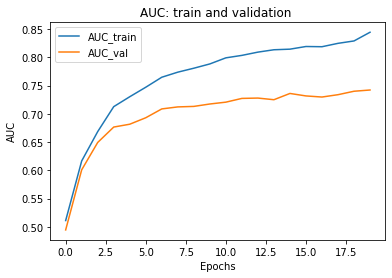

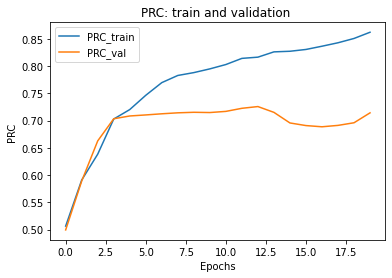

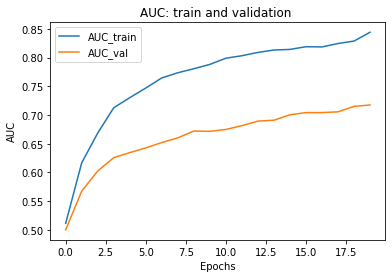

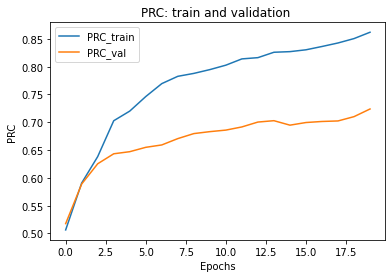

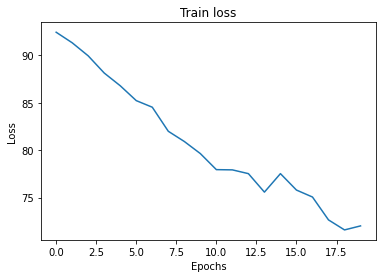

In [ ]:
# Path where the training will be saved
# dir = 'output/5-fold-paper('+str(fold)+')'  # Comment if grid search is used
dir = 'output/drop0.25reg0.1_paper('+str(fold)+')' 
cr_date = datetime.now()
date = cr_date.strftime("%Y-%m-%d_%H-%M-%S")
path = dir+ date+'/' 
os.mkdir(path)

#call the model
AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss = train_model(path,dataset_train,dataset_dev,dataset_test, params)

# Grid search

In [ ]:
from sklearn.model_selection  import ParameterGrid
param_grid = {'dataset_part' : [0.08],
              'protein_dim' : [100],
              'atom_dim' : [34] ,
              'hid_dim' : [64] ,
              'n_layers' : [3] ,
              'n_heads' : [8] ,
              'pf_dim' : [256],
              'dropout' : [0.1,0.2],
              'batch' : [64],
              'lr' : [1e-4],
              'weight_decay' : [1e-4],
              'decay_interval' : [5],
              'lr_decay' : [1.0],
              'iteration' : [2],
              'kernel_size':[7]}
grid = ParameterGrid(param_grid)

In [ ]:
"""Create a dataset and split it into train/dev/test."""
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset,dataset_test = split_dataset(dataset, dataset_part)

dataset_train, dataset_dev = split_dataset(dataset, 0.8)
dataset_test = dataset_test[0:len(dataset_dev)]

# print('total size',len(dataset))
# for i_fold in range(5):
#   dataset_train, dataset_dev = get_kfold_data(i_fold, dataset)
#   print('data size',len(dataset_train),len(dataset_dev))

Fit number  0 / 2
------------------------------
atom_dim:34
batch:64
dataset_part:0.08
decay_interval:5
dropout:0.1
hid_dim:64
iteration:2
kernel_size:7
lr:0.0001
lr_decay:1.0
n_heads:8
n_layers:3
pf_dim:256
protein_dim:100
weight_decay:0.0001
------------------------------
Training...
Epoch	Time(sec)	AUC_dev	PRC_dev	loss_train	AUC_dev	AUC_train	PRC_train	PRC_dev
epoch  1
1	11.0874	0.5298	0.578	9.2989	0.5298	0.4845	0.4461	0.578
epoch  2
2	19.5011	0.5298	0.578	9.2532	0.5298	0.4894	0.4501	0.578


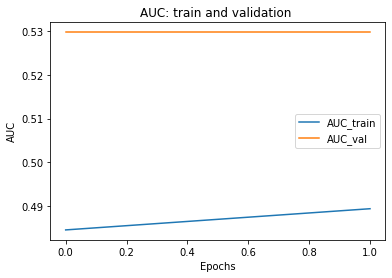

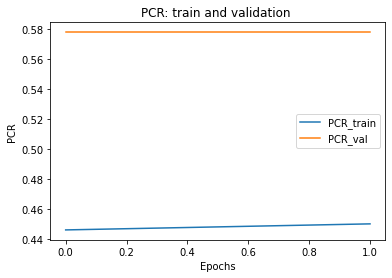

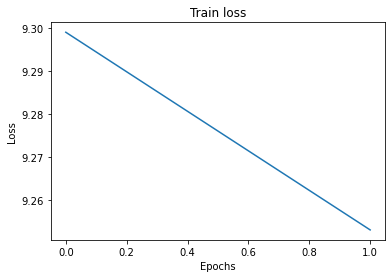

Fit number  1 / 2
------------------------------
atom_dim:34
batch:64
dataset_part:0.08
decay_interval:5
dropout:0.2
hid_dim:64
iteration:2
kernel_size:7
lr:0.0001
lr_decay:1.0
n_heads:8
n_layers:3
pf_dim:256
protein_dim:100
weight_decay:0.0001
------------------------------
Training...
Epoch	Time(sec)	AUC_dev	PRC_dev	loss_train	AUC_dev	AUC_train	PRC_train	PRC_dev
epoch  1
1	8.2272	0.381	0.5426	8.9517	0.381	0.5446	0.5024	0.5426
epoch  2
2	15.5691	0.375	0.5401	8.9788	0.375	0.5472	0.5035	0.5401


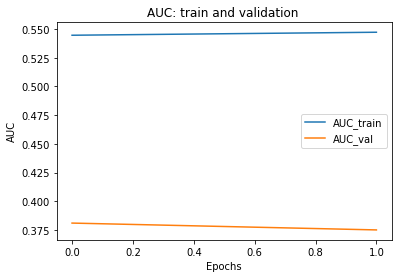

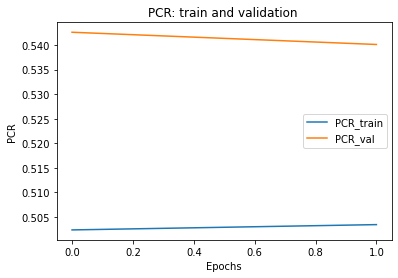

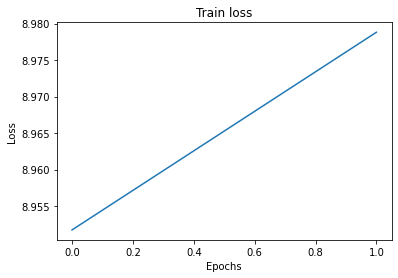

The best combination is: {'weight_decay': 0.0001, 'protein_dim': 100, 'pf_dim': 256, 'n_layers': 3, 'n_heads': 8, 'lr_decay': 1.0, 'lr': 0.0001, 'kernel_size': 7, 'iteration': 2, 'hid_dim': 64, 'dropout': 0.1, 'decay_interval': 5, 'dataset_part': 0.08, 'batch': 64, 'atom_dim': 34} with an accuracy of  0.5297619047619048


In [ ]:
#deberia crear tb un test set

# Path where the grid search will be saved
cr_date = datetime.now()
date = cr_date.strftime("%Y-%m-%d_%H-%M-%S")
dir = 'output/'+'grid-'+ date+'/' 
os.mkdir(dir)

model_acc = []
for i,params in enumerate(grid):
  print('Fit number ',i,'/',len(grid))
  
  # Path where the training will be saved
  # dir = 'output/'  # Comment if grid search is used
  cr_date = datetime.now()
  date = cr_date.strftime("%Y-%m-%d_%H-%M-%S")
  path = dir+ date+'/' 
  os.mkdir(path)


  #call the model
  AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss = train_model(path,dataset_train,dataset_dev,dataset_test, params)
  model_acc.append(AUCs_test[-1])

best = np.argmax(np.array(model_acc))
print('The best combination is:',grid[best], 'with an accuracy of ',model_acc[best])
with open(dir+'results'+'.txt', 'a') as f:
  f.write(str(param_grid)+'\n')
  f.write('The best combination is:' + str(grid[best]) + 'with an accuracy of ' + str(model_acc[best]))


# Single training

In [ ]:
params = {'dataset_part' : 0.1,
              'protein_dim' : 100,
              'atom_dim' : 34 ,
              'hid_dim' : 64 ,
              'n_layers' : 3 ,
              'n_heads' : 8 ,
              'pf_dim' : 158,
              'dropout' : 0.01,
              'batch' : 64,
              'lr' : 1e-4,
              'weight_decay' : .01,
              'decay_interval' : 5,
              'lr_decay' : .9,
              'iteration' : 20,
              'kernel_size':7,
              'remove_trans_layer': 0,
              'opt_':'adam'}

# params = {'dataset_part' : 0.1,
#               'protein_dim' : 100,
#               'atom_dim' : 34 ,
#               'hid_dim' : 64 ,
#               'n_layers' : 3 ,
#               'n_heads' : 8 ,
#               'pf_dim' : 512,
#               'dropout' : 0.2,
#               'batch' : 8,
#               'lr' : 1e-4,
#               'weight_decay' : 1e-4,
#               'decay_interval' : 5,
#               'lr_decay' : 1.0,
#               'iteration' : 20,
#               'kernel_size':7,
#               'remove_trans_layer': 0,
#               'opt_':'radam'}

In [ ]:
"""Create a dataset and split it into train/dev/test."""
dataset = list(zip(compounds, adjacencies, proteins, interactions))
dataset = shuffle_dataset(dataset, 1234)
dataset,dataset_test = split_dataset(dataset, params['dataset_part'])

dataset_train, dataset_dev = split_dataset(dataset, 0.8)
dataset_test = dataset_test[0:len(dataset_dev)]

# print('total size',len(dataset))
# for i_fold in range(5):
#   dataset_train, dataset_dev = get_kfold_data(i_fold, dataset)
#   print('data size',len(dataset_train),len(dataset_dev))

In [ ]:
print(len(dataset_train), len(dataset_dev),len(dataset_test))

1041 261 261


------------------------------
dataset_part:0.1
protein_dim:100
atom_dim:34
hid_dim:64
n_layers:3
n_heads:8
pf_dim:158
dropout:0.01
batch:64
lr:0.0001
weight_decay:0.01
decay_interval:5
lr_decay:0.9
iteration:20
kernel_size:7
remove_trans_layer:0
opt_:adam
------------------------------
Training...
epoch   time   loss_train   AUC_test   AUC_dev   AUC_train   PRC_test   PRC_dev   PRC_train
epoch  1
1	28.492	94.7214	0.5425	0.5343	0.6262	0.5384	0.58	0.5985
epoch  2
2	56.6359	88.5582	0.6006	0.5796	0.6998	0.5856	0.609	0.6837
epoch  3
3	86.1348	84.7543	0.6563	0.6085	0.7489	0.6572	0.6335	0.7261
epoch  4
4	114.5578	81.8209	0.683	0.6213	0.7681	0.6874	0.6497	0.7469
epoch  5
5	142.7831	77.5987	0.7038	0.6439	0.7867	0.7095	0.6722	0.7758
epoch  6
6	171.2174	74.332	0.7277	0.6713	0.8077	0.7446	0.6953	0.7949
epoch  7
7	199.57	72.3231	0.7326	0.6942	0.8264	0.7529	0.712	0.8266
epoch  8
8	227.4577	69.0995	0.7386	0.6982	0.8353	0.7479	0.7248	0.8328
epoch  9
9	255.7559	65.6284	0.7447	0.7084	0.8389	0.7593	0.74

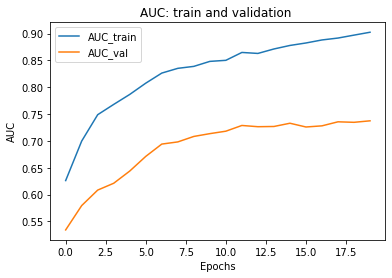

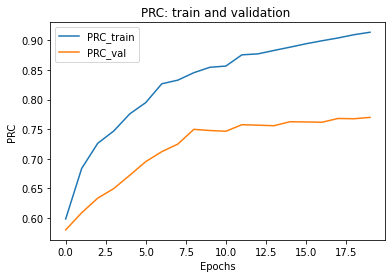

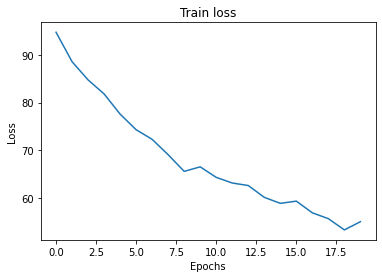

In [ ]:
# Path where the training will be saved
dir = 'output/'  # Comment if grid search is used
cr_date = datetime.now()
date = cr_date.strftime("%Y-%m-%d_%H-%M-%S")
path = dir+ date+'/' 
os.mkdir(path)

#call the model
AUCs_train,PRCs_train,AUCs_val,PRCs_val,AUCs_test,PRCs_test,train_loss = train_model(path,dataset_train,dataset_dev,dataset_test, params)

# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
embedding = np.empty((len(embedd),embedd[0].shape[0]))
label = np.empty((len(embedd)))
print(embedding.shape)
for i in range(len(embedd)):
  embedding[i,:] = embedd[i]
  label[i]=labell[i][0]
print(embedding.shape)
label = list(label.astype(int))

(1000, 256)
(1000, 256)


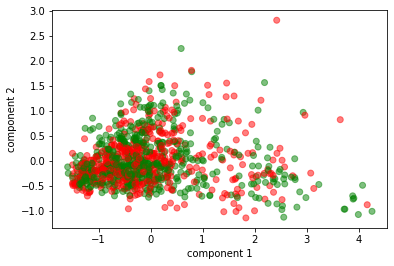

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding)
pca_result.shape

In [ ]:
from sklearn.manifold import TSNE
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(embedding)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.459974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.182503
[t-SNE] KL divergence after 1000 iterations: 0.893777


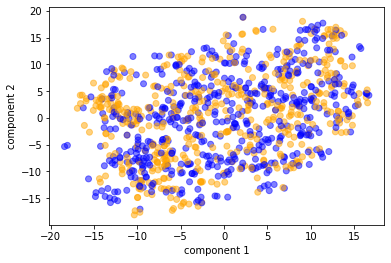

In [ ]:
colors = ['orange','blue']
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            alpha=0.5, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

# PCA embeddings

In [ ]:
proteins[0].shape

torch.Size([353, 100])

In [ ]:
proteins2 = proteins.copy()

In [ ]:
num_samples = 1000 #(len(proteins)
prot_pca = np.empty((num_samples,100))

In [ ]:
from sklearn.decomposition import PCA
for i in range(num_samples):#len(proteins)):
  if i%100==0:
    print(i)
  pca = PCA(n_components=1)
  embedd = pca.fit_transform(proteins[i].T).flatten()
  prot_pca[i,:] = pca.fit_transform(proteins[i].T).flatten()

0
100
200
300
400
500
600
700
800
900


In [ ]:
prot_pca.shape

(1000, 100)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
pca = PCA(n_components=2)
pca_result = pca.fit_transform(prot_pca)
pca_result.shape

(1000, 2)

In [ ]:
label = []
for i in range(pca_result.shape[0]):
  label.append(interactions[i][0].item())

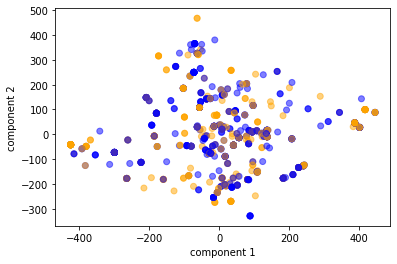

In [ ]:
colors = ['orange','blue']
plt.scatter(pca_result[:, 0], pca_result[:, 1],
            alpha=0.5, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto', init='random')
tsne_results = tsne.fit_transform(prot_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.817894
[t-SNE] KL divergence after 1000 iterations: 0.164754


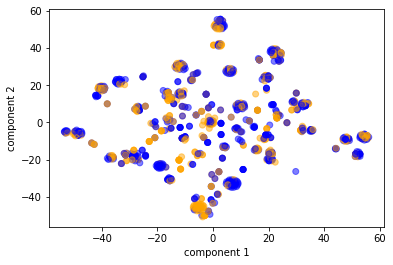

In [ ]:
colors = ['orange','blue']
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            alpha=0.5, c=label, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

# Tests

Friedman test

In [ ]:
# Friedman test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
# seed the random number generator
seed(1)
# generate three independent samples
data1 = [0.7007 , 0.7012 , 0.6894 , 0.6948 , 0.6959] #0.6954
data2 = [0.7025 , 0.7028	,0.6974	,0.6888	,0.7133] #0.7010
data3 = [0.7279	, 0.7146, 0.7151 ,0.7066,0.722] #0.7172
data4 = [0.7103	,0.7259	,0.6967	,0.7047	,0.7098] #0.70948
data5 = [0.7104	,0.7318	,0.7209	,0.7131	,0.7137] #0.71798
# compare samples
stat, p = friedmanchisquare(data1, data2, data3, data4, data5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=15.840, p=0.003
Different distributions (reject H0)


In [ ]:
# Kruskal-Wallis H-test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import wilcoxon
# seed the random number generator
seed(1)

# compare samples
stat, p = wilcoxon(data4, data5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=0.000, p=0.043
Different distributions (reject H0)


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
